<table width="100%"><tr><td style="color:#bbbbbb;background-color:#ffffff;font-size:11px;font-style:italic;text-align:right;">This cell contains some macros. If there is a problem with displaying mathematical formulas, please run this cell to load these macros. </td></tr></table>
$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\dot}[2]{ #1 \cdot #2} $
$ \newcommand{\biginner}[2]{\left\langle #1,#2\right\rangle} $
$ \newcommand{\mymatrix}[2]{\left( \begin{array}{#1} #2\end{array} \right)} $
$ \newcommand{\myvector}[1]{\mymatrix{c}{#1}} $
$ \newcommand{\myrvector}[1]{\mymatrix{r}{#1}} $
$ \newcommand{\mypar}[1]{\left( #1 \right)} $
$ \newcommand{\mybigpar}[1]{ \Big( #1 \Big)} $
$ \newcommand{\sqrttwo}{\frac{1}{\sqrt{2}}} $
$ \newcommand{\dsqrttwo}{\dfrac{1}{\sqrt{2}}} $
$ \newcommand{\onehalf}{\frac{1}{2}} $
$ \newcommand{\donehalf}{\dfrac{1}{2}} $
$ \newcommand{\hadamard}{ \mymatrix{rr}{ \sqrttwo & \sqrttwo \\ \sqrttwo & -\sqrttwo }} $
$ \newcommand{\vzero}{\myvector{1\\0}} $
$ \newcommand{\vone}{\myvector{0\\1}} $
$ \newcommand{\vhadamardzero}{\myvector{ \sqrttwo \\  \sqrttwo } } $
$ \newcommand{\vhadamardone}{ \myrvector{ \sqrttwo \\ -\sqrttwo } } $
$ \newcommand{\myarray}[2]{ \begin{array}{#1}#2\end{array}} $
$ \newcommand{\X}{ \mymatrix{cc}{0 & 1 \\ 1 & 0}  } $
$ \newcommand{\Z}{ \mymatrix{rr}{1 & 0 \\ 0 & -1}  } $
$ \newcommand{\Htwo}{ \mymatrix{rrrr}{ \frac{1}{2} & \frac{1}{2} & \frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & -\frac{1}{2} & \frac{1}{2} & -\frac{1}{2} \\ \frac{1}{2} & \frac{1}{2} & -\frac{1}{2} & -\frac{1}{2} \\ \frac{1}{2} & -\frac{1}{2} & -\frac{1}{2} & \frac{1}{2} } } $
$ \newcommand{\CNOT}{ \mymatrix{cccc}{1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0} } $
$ \newcommand{\norm}[1]{ \left\lVert #1 \right\rVert } $
$ \newcommand{\pstate}[1]{ \lceil \mspace{-1mu} #1 \mspace{-1.5mu} \rfloor } $

#  Quantum Approximate Optimization Algorithm (QAOA)

In this notebook, we will introduce the Quantum Approximate Optimization Algorithm (QAOA) and see how to implement the algorithm for the Max-Cut problem using pyQuil, the Python library for quantum programming using Quil from Rigetti Computing following [1]. Instructions on how to install pyQuil can be found [here](https://pyquil-docs.rigetti.com/en/stable/index.html).


## What is QAOA?

QAOA, first introduced by Farhi et al. [2], is a hybrid quantum-classical algorithm (using both classical and quantum computation) that helps find an approximate solution for combinatoral optimization problems. 


## What are Combinatorial Optimization Problems?

In a combinatorial optimization problem, the goal is that given some binary constraints $\alpha$ over bitstrings of length n, $\it{z}\in \{0,1\}^{n}$, we want to find the bitstring that maximizes the objective function
$$
\text{argmax}_{\it{z}}C (\it{z}) = \text{argmax}_{\it{z}} \sum_{\alpha =1}^{m} C (\it{z}),
$$
where 
$$
C_{\alpha} (\it{z}) = \begin{cases}
1, & \text{if} \, \it{z} \, \text{satisfies the constraint} \, \alpha \\
0, & \text{if} \, \it{z} \, \text{does not satisfy the constraint} \,\alpha
\end{cases}
$$

are functions that takes in a bitstring and outputs $0$ or $1$, depending on whether it satisfies the constraint. 

There are various different examples such as the Traveling Salesman problem and Max-Cut problem. Here, we will focus on solving a Max-Cut problem with QAOA.


## Why QAOA?

In QNickel, we saw an example of solving the Max-Cut problem with Grover's algorithm, so the question is why use QAOA? The answer is although there has been great progress, we do not have fault-tolerant quantum computers yet. So in the meantime, we use a quantum-classical hybrid approach, so that we only use quantum computers for parts of the problem where cassical computers having difficulty computing.

## How does QAOA work?

QAOA is a hybrid algorithm. A general hybrid algorithm works as follows.

<img src="Hybrid.png" width="50%">

There is a classical processing unit (CPU) and quantum processing unit (QPU). The idea is:

1) The CPU sends a parametrized circuit to the QPU with some initial guess of parameters.

2) The QPU will then run this circuit for a number of shots for some observable to get a sample.

3) We feed the sample back to the CPU. 

4) The CPU can then further optimize parameters for the objective function.

You repeat this cycle until you get a convergence to a good choice of parameters that optimizes your objective function.



## Application of QAOA to the Max-Cut Problem

Now let us look at a more specific example, the Max-Cut problem with QAOA. Consider the folowing undirected graph with three nodes and three edges.

<img src="Three.png" width="25%" align="center">



The Max-Cut problem is to find a partition of the nodes of the such that the edges between them is maximum or the maximum number of cuts of edges such that the ends of nodes are different colors. We can easily see that for this graph, the Max-Cut would be two and we choose to represent the partition of nodes with two colors, red and blue. Any of the following would be valid cuts/partitions.

<img src="Cuts.png" width="75%" align="center">

The solution to this problem can also be represented in binary format with qubits by taking the three nodes of the graph to be three qubits, then allocate the state $\ket{0}$ or $\ket{1}$ to represent the color (red/blue) of or which partition the node belongs to. For the present graph, our solution can be represented by any of the following states $\ket{001},\ket{110},\ket{100},\ket{011},\ket{101},\ket{010}$.

To use QAOA to help us find these solutions, let us start with the Hadamard state as the initial state

$$
\ket{+} = \frac{1}{\sqrt{2^{n}}}\sum_{x=0}^{2^{n}-1}\ket{x},
$$

which is just the equal superposition of all possible answers. This state will go throuh a parametrized quantum circuit that is made of a chain of 'Cost (C)' (specific to the Max-Cut problem and the function we want to maximize) 

$$
H_{C}\left( \gamma\right) = e^{-i\gamma C} \quad \text{where} \quad \text{C}=\frac{1}{2}\sum_{i,j=0}^{n-1}\omega_{ij}\frac{1-Z_{i}Z_{j}}{2},
$$

and 'Mixer (M)' Hamiltonians 

$$
H_{M}\left( \beta\right) = e^{-i\beta B} \quad \text{where} \quad \text{M}=\sum_{j=0}^{n-1}X_{j}.
$$

$n-1$ represents the number of nodes in our problem and $\omega_{ij}$ is the weight between the $i^{th}$ and $j^{th}$ nodes. So if there exists an edge between the two nodes, we give this a weight of one, if there does not exist an edge, then a weight of zero.

The final state
$$
\ket{\psi} = e^{-i\beta_{p}M}e^{-i\gamma_{p}C}\cdots e^{-i\beta_{1}M}e^{-i\gamma_{1}C}\ket{+}
$$

is the result of acting the chain of alternating Cost and Mixer Hamiltonians on our initial state. $p$ defines the number of layers, i.e. the number of times we act with $H_{C}H_{M}$, then we can take measurements. The quantum circuit will look like the following.

<img src="Layers.png" width="75%">


Now, there are two remaining components we have not discussed. First are the parameters $\beta$ and $\gamma$. These are the parameters we would like to optimize in order to help us reach the optimal solution. Second are the Mixer (M) and Cost (C) terms. M composes of $X_{j}$'s which acts individually on every qubit and C is composed of two-qubit terms, $Z_{i}Z_{j}$ on the $i^{th}$ and $j^{th}$ qubits respectively. But what happens when we exponentiate them? This is where we need to introduce a new formula called the Baker-Campbell-Hausdorff (BCH) Formula.


### Baker-Campbell-Hausdorff (BCH) Formula

The BCH formula is given by

$$
e^{X}e^{Y} = e^{Z} \quad \text{where} \quad Z = X+Y \quad \text{if} \quad [X,Y] =0.
$$

Note the condition $[X,Y] =0$. This means our formula is only valid only when the two operators $X$ and $Y$ commute and hence as

\begin{align}
[Z_{i}Z_{j},Z_{m}Z_{n}] &=0,\\
[X_{i},X_{j}]&=0,
\end{align}

then

\begin{align}
e^{i\beta\sum_{i}X_{i}} &=  \prod_{i} e^{i\beta X_{i}} = (e^{i\beta X_{0}})\cdots(e^{i\beta X_{n-1}}),\\
e^{i\gamma\sum_{\langle ij\rangle } Z_{i}Z_{j}} &=  \prod_{\langle ij\rangle } e^{i\gamma Z_{i}Z_{j}}= (e^{i\gamma Z_{0}Z_{1}})\cdots(e^{i\gamma Z_{n-2}Z_{n-1}}).\\
\end{align}

$e^{-i\beta X_{i}}$ is a rotation about the X-axis, which is the single-qubit gate $RX(2\beta )$ and we can check

\begin{align}
 e^{-i\beta X_{i}}\ket{0}_{i}&=\cos\beta\ket{0}-i\sin\beta\ket{1},\\
 e^{-i\beta X_{i}}\ket{1}_{i}&=\cos\beta\ket{1}-i\sin\beta\ket{0}.
\end{align}

$e^{-i\gamma Z_{i}Z_{j}}$ is a two-qubit operation which changes the sign of our phase from negative to positive whenever the two qubits are in different states, i.e. $\ket{0}_{i}\ket{1}_{j}$ or $\ket{1}_{i}\ket{0}_{j}$. 

\begin{align}
e^{-i\gamma Z_{i}Z_{j}}\ket{0}_{i}\ket{0}_{j}&=e^{-i\gamma}\ket{0}_{i}\ket{0}_{j} \quad e^{-i\gamma Z_{i}Z_{j}}\ket{0}_{i}\ket{1}_{j}=e^{i\gamma}\ket{0}_{i}\ket{1}_{j}\\
e^{-i\gamma Z_{i}Z_{j}}\ket{1}_{i}\ket{1}_{j}&=e^{-i\gamma}\ket{1}_{i}\ket{1}_{j} \quad e^{-i\gamma Z_{i}Z_{j}}\ket{1}_{i}\ket{0}_{j}=e^{i\gamma}\ket{1}_{i}\ket{0}_{j}\\
\end{align}

Translating this to our graph, this just means that the nodes at the end of the edge are in different colors or partitions. We can check $e^{-i\gamma Z_{i}Z_{j}}$ can be given by the following quantum circuit

<img src="Cost.png" width="40%">


Now we have all the ingredients to start coding our quantum circuit. To begin, it is always nice to have a visual of our graph. The Python package NetworkX is great for this.

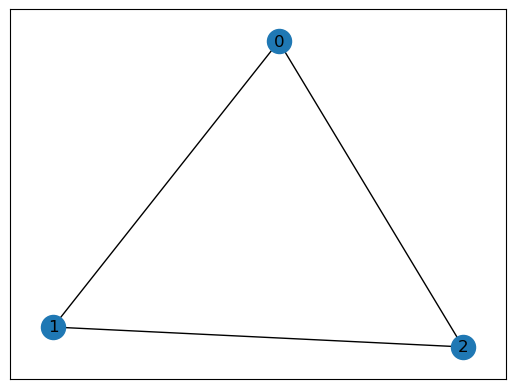

In [86]:
import networkx as nx
# Define the nodes of our graph
qubits = [0, 1, 2]
# Initialize an empty graph
G = nx.Graph()
# Define the edges
G.add_edges_from([(qubits[0], qubits[1]), (qubits[1], qubits[2]), (qubits[2], qubits[0])])
# Plot the graph
nx.draw_networkx(G)

Now we shall write our QAOA program with pyQuil. We will be using the `WavefunctionSimulator` for simulation of our quantum circuit.

In [87]:
from pyquil import Program
from pyquil.api import WavefunctionSimulator
from pyquil.gates import *
from pyquil.paulis import *

wfn_sim = WavefunctionSimulator()

Let us define the Cost and Mixer terms. This is pretty straightforward. We can simplify the Cost term such that the problem becomes finding the minimum of $\sum ZZ$ instead of the maximum of $\frac{1}{2} \sum I - ZZ$. The Mixer term is $\sum X$.

In [88]:
q0, q1, q2 = qubits
# Cost term
cost = sZ(q0) * sZ(q1) + sZ(q1) * sZ(q2) + sZ(q0) * sZ(q2) 
# Mixer term
mixer = sX(q0) + sX(q1)+ sX(q2)

Then, we build the quantum circuit as explained above. We shall take $p=1$, which means we just have two parametric variables $\gamma_{1}, \beta_{1}$, i.e. one layer. The initial state as discussed above is the Hadamard state. We also use `exponential_map` from pyQuil to exponentiate the Cost and Mixer terms.

In [62]:
# Initialize an empty Program
qaoa_prog = Program()

# Declare the parametric variables 
gamma = qaoa_prog.declare('gamma', 'REAL', 1)
beta = qaoa_prog.declare('beta', 'REAL', 1)

# Create the initial state with Hadamard gates
for q in qubits:
    qaoa_prog += H(q)
    
# Add the Cost Hamiltonian to our circuit
for cost_term in cost:
    qaoa_prog += exponential_map(cost_term)(gamma)
    
# Add the Mixer Hamiltonian
for mixer_term in mixer:
    qaoa_prog += exponential_map(mixer_term)(beta)

Now, we choose two values for the parametric variables, run the quantum simulation for a number of times and print the output states.

In [99]:
gamma = beta = 0.1

# Wavefunction
wfn = wfn_sim.wavefunction(qaoa_prog, memory_map={'gamma': [gamma], 'beta': [beta]})

# Shots
samples = wfn.sample_bitstrings(n_samples=100)

# List shots
sampleslist=[]
for y in range(len(samples)-1):
    sampleslist.append(''.join([str(x) for x in samples[y]]))
    
sampleslistint=[]
for z in range(len(sampleslist)-1):
    sampleslistint.append(int(sampleslist[z], base=2))

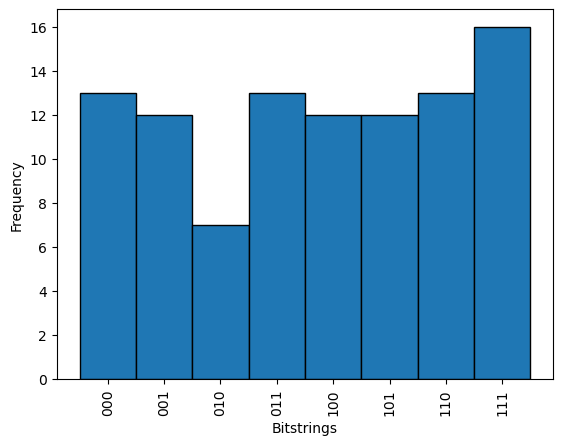

In [100]:
import matplotlib.pyplot as plt

xticks = range(2**len(qubits))
xtick_labels = list(map(lambda x: format(x, "03b"), xticks))
bins = np.arange(0, 2**len(qubits)+1) - 0.5

plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(sampleslistint, bins=bins, edgecolor='black')
plt.show()

Let us also compute the expectation. This is the value that we want to minimize in order to find our optimal solution.

In [67]:
expect = wfn_sim.expectation(qaoa_prog, cost, memory_map={'gamma': [gamma], 'beta': [beta]})
print(np.abs(expect))

0.2321434929904852


Since our Hamiltonian problem is still rather simple, we can compute the true minimum eigenvalue to compare with the expectation.

In [69]:
from pyquil.simulation.tools import lifted_pauli

# Obtain the matrix form of the Cost Hamiltonian
mat = lifted_pauli(cost, cost.get_qubits())

# Obtain Cost Hamiltonian eigenvalues
eigvals, eigvecs = np.linalg.eig(mat)

# Obtain the minimum eigenvalue
min_eigval = np.min(eigvals)

# Print the minimum eigenvalue, checking it is real
assert np.isclose(min_eigval.imag, 0.0)   
min_eigval = np.real(min_eigval)
print(f"Min eigenvalue: {np.abs(min_eigval)}")

Min eigenvalue: 1.0


Now let use continue by carrying out a classical optimization. There exists many different optimization methods. Some are gradient-based, meaning one needs to provide information on the gradient to optimize, others do not. We shall use one of the latter ones called `COBYLA` from the [SciPy Optimization Library](https://docs.scipy.org/doc/scipy/reference/optimize.html).

In [14]:
from scipy.optimize import minimize

In [15]:
# Objective function for optimization
def objective(angles):
    global wfn_sim
    global qaoa_prog
    global cost
    gamma, beta = angles
    obs = wfn_sim.expectation(qaoa_prog, cost, memory_map={'gamma': [gamma], 'beta': [beta]})
    return obs

In [75]:
initial_guess = [gamma, beta]

result = minimize(objective, x0=initial_guess, method='COBYLA')

print(f"Success: {result.success}")
print(f"Optimal value: {np.abs(result.fun)}")
print(f"Optimal angles: {result.x}")


Success: True
Optimal value: 0.9999999635400805
Optimal angles: [1.26300963 0.30775723]


How does the optimization compare before and now after running COBYLA? Let us run quantum simulations again, but now with optimized parameters.

In [102]:
gamma = res.x[0]
beta = res.x[1]

# Optimized wavefunction
wfn = wfn_sim.wavefunction(qaoa_prog, memory_map={'gamma': [gamma], 'beta': [beta]})

# Shots from optimized wavefunction
samples = wfn.sample_bitstrings(n_samples=100)

# List shots
sampleslist=[]
for y in range(len(samples)-1):
    sampleslist.append(''.join([str(x) for x in samples[y]]))

sampleslistint=[]
for z in range(len(sampleslist)-1):
    sampleslistint.append(int(sampleslist[z], base=2))


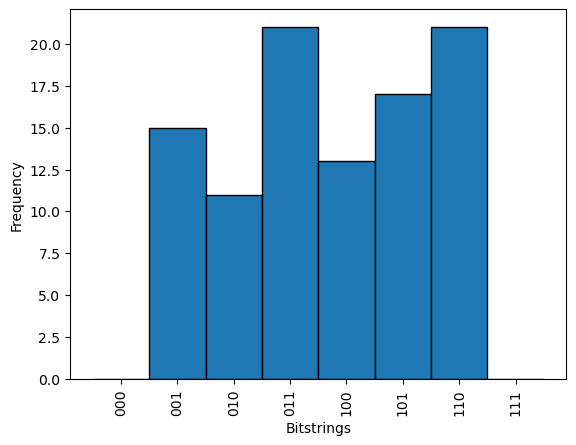

In [103]:
import matplotlib.pyplot as plt

xticks = range(2**len(qubits))
xtick_labels = list(map(lambda x: format(x, "03b"), xticks))
bins = np.arange(0, 2**len(qubits)+1) - 0.5

plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(sampleslistint, bins=bins, edgecolor='black')
plt.show()

### Task 1

Repeat the above example for larger rings / polygons. What do you notice about the perfomance?


### Task 2

Repeat Task 1 for more layers of the quantum circuit, i.e. for $p=2,3$ etc. What do you notice about the perfomance now?


### References

[1] S. Alam, Rigetti Computing Lectures, IBA Karachi (2020).

[2] E. Farhi, J. Goldstone, and S. Gutmann, A Quantum Approximate Optimization Algorithm, arXiv.1411.4028 (2014).